In [11]:
from time import time
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel

# Load Dinov2 processor and model
# Available size variants: "facebook/dinov2-small", "facebook/dinov2-base", "facebook/dinov2-large", "facebook/dinov2-giant"
# Change the model_name below to use a different size variant
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().to(torch.device('cuda'))

# Load your images
# image1 = Image.open("datasets/mono/MH004/000002.png").convert("RGB")
image1 = Image.open("datasets/mono/MH007/000930.png").convert("RGB")
image2 = Image.open("datasets/TartanAir/AbandonedFactory/P001/image_left/000002_left.png").convert("RGB")

import time
start = time.time()
inputs = processor([image1], return_tensors="pt")
inputs = {k: (v.to(model.device) if isinstance(v, torch.Tensor) else v) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

# reshape patch tokens (exclude [CLS]) into a spatial feature map B x C x H x W
patch_tokens = outputs.last_hidden_state[:, 1:, :]  # (B, N_patches, C)
B, N, C = patch_tokens.shape
print(B, N, C)
H = W = int(N ** 0.5)
feature_map = patch_tokens.transpose(1, 2).reshape(B, C, H, W)

# keep for downstream use if needed
embeddings = feature_map

end = time.time()
print(f"Time taken: {end - start:.5f} seconds")
print(feature_map.shape)

1 256 768
Time taken: 0.00521 seconds
torch.Size([1, 768, 16, 16])


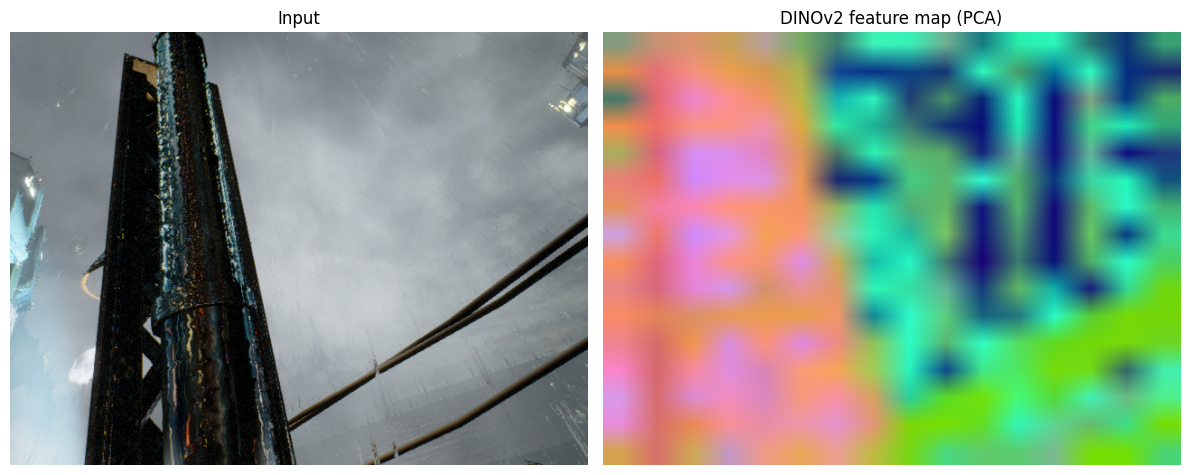

In [12]:
# Visualize DINOv2 feature map (PCA to RGB), upsampled to image1 size
import matplotlib.pyplot as plt
# pick the 4D feature map tensor
try:
    fmap4d = embeddings  # (B, C, H, W) from cell 0
except NameError:
    fmap4d = feature_map

with torch.no_grad():
    fmap = fmap4d[0].detach().float().cpu()  # C x h x w
    C, h, w = fmap.shape

    # flatten spatial dims and center features
    x = fmap.permute(1, 2, 0).reshape(-1, C)
    x = x - x.mean(0, keepdim=True)

    # project to 3 components (PCA via pca_lowrank)
    _, _, V = torch.pca_lowrank(x, q=3, center=False)
    x3 = x @ V[:, :3]

    # per-channel min-max normalization to [0,1]
    mins = x3.min(0, keepdim=True).values
    maxs = x3.max(0, keepdim=True).values
    x3 = (x3 - mins) / (maxs - mins + 1e-6)

    # reshape to image and upsample to input image size
    rgb = x3.reshape(h, w, 3).permute(2, 0, 1).unsqueeze(0)  # 1x3xhxw
    rgb_up = torch.nn.functional.interpolate(
        rgb, size=image1.size[::-1], mode="bilinear", align_corners=False
    ).squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()

# show input and feature map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(rgb_up)
ax[1].set_title("DINOv2 feature map (PCA)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

## Maskformer Instance Segmentation

/home/user/anaconda3/envs/dpvo118_backup/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


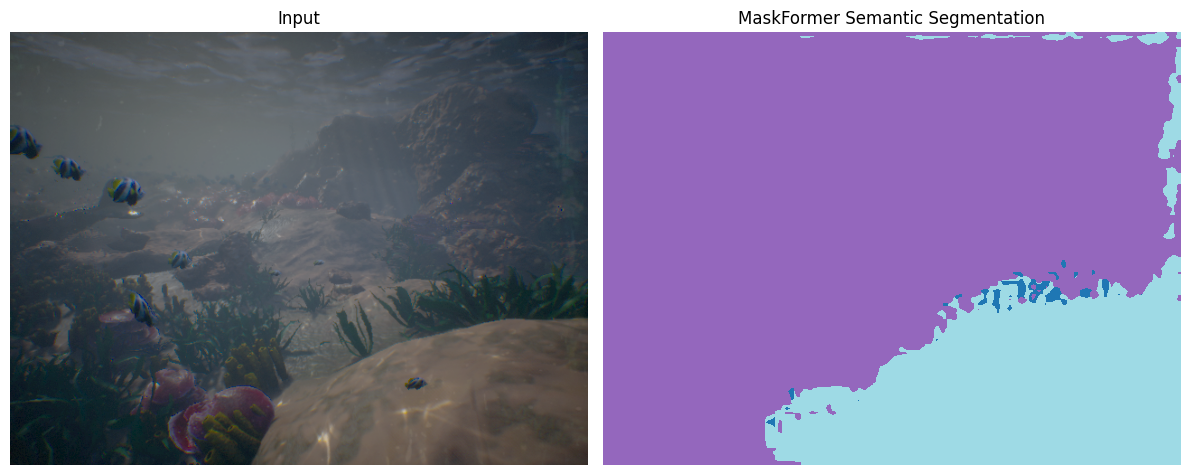

Unique class ids: [0, 33, 77]
Inference avg: 22.28 ms/img (44.87 FPS) over 20 runs


In [13]:
from transformers import Mask2FormerForUniversalSegmentation, AutoImageProcessor
import torch 
import matplotlib.pyplot as plt
from pathlib import Path

# Load MaskFormer model and processor (semantic segmentation on ADE20k)
seg_model_name = "facebook/mask2former-swin-large-coco-instance" ## Badddd
seg_processor = AutoImageProcessor.from_pretrained(seg_model_name)
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(seg_model_name).eval().to(torch.device('cuda'))


# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater


seg_inputs = seg_processor(images=image1, return_tensors="pt")
seg_inputs = {k: (v.to(seg_model.device) if isinstance(v, torch.Tensor) else v) for k, v in seg_inputs.items()}

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Post-process to obtain semantic segmentation mask at image resolution
seg_result = seg_processor.post_process_semantic_segmentation(
    outputs=seg_outputs, target_sizes=[image1.size[::-1]]
)[0]  # (H, W) tensor with class ids

# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Semantic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optional: print unique class ids present
print("Unique class ids:", sorted(set(seg_result.cpu().numpy().ravel().tolist())))

# set your desired save directory
save_dir = f"seg_models/{seg_model_name}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(seg_model.parameters()).device
seg_model.to("cpu")
seg_model.save_pretrained(save_dir)
seg_processor.save_pretrained(save_dir)
seg_model.to(_prev_device)

# Benchmark inference time (forward pass only)
warmup = 5
runs = 20

with torch.no_grad():
    for _ in range(warmup):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()

t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")

## Maskformer panotpic 

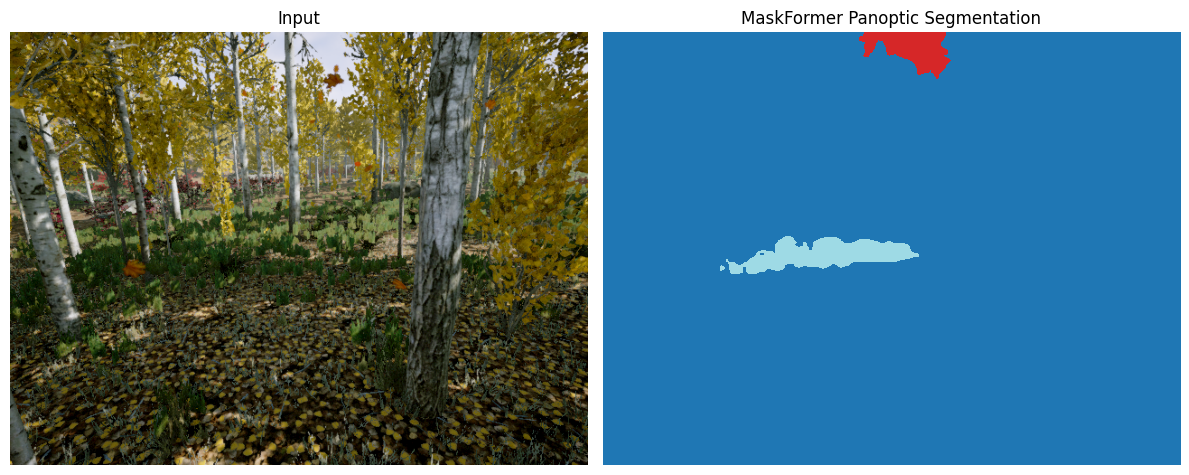

Unique class ids: [116, 119, 125]
Inference avg: 17.43 ms/img (57.37 FPS) over 20 runs


In [14]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from pathlib import Path


# model = "facebook/mask2former-swin-large-cityscapes-panoptic"  ## Badd
# model = 'facebook/mask2former-swin-large-coco-panoptic' ## Pretty decent
model = 'facebook/mask2former-swin-base-coco-panoptic' ## Pretty decent

seg_processor = AutoImageProcessor.from_pretrained(model)
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(model)
seg_model = seg_model.eval().to(torch.device('cuda'))

# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
# image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater
# image1 = Image.open("datasets/mono/ME005/000050.png").convert("RGB") ## indoor offfice
image1 = Image.open("datasets/mono/ME006/000021.png").convert("RGB") ## dense forest
# image1 = Image.open("datasets/mono/ME007/000021.png").convert("RGB") ## desert

seg_inputs = seg_processor(images=image1, return_tensors="pt")
seg_inputs = {k: (v.to(seg_model.device) if isinstance(v, torch.Tensor) else v) for k, v in seg_inputs.items()}

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Post-process to obtain semantic segmentation mask at image resolution
seg_result = seg_processor.post_process_semantic_segmentation(
    outputs=seg_outputs, target_sizes=[image1.size[::-1]]
)[0]  # (H, W) tensor with class ids

# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Panoptic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optional: print unique class ids present
print("Unique class ids:", sorted(set(seg_result.cpu().numpy().ravel().tolist())))

# set your desired save directory
save_dir = f"seg_models/{model}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(seg_model.parameters()).device
seg_model.to("cpu")
seg_model.save_pretrained(save_dir)
seg_processor.save_pretrained(save_dir)
seg_model.to(_prev_device)



# Benchmark inference time (forward pass only)
warmup = 5
runs = 20

with torch.no_grad():
    for _ in range(warmup):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()

t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")

### Seperating encoder and decoder

In [15]:
print(seg_model.model)

Mask2FormerModel(
  (pixel_level_module): Mask2FormerPixelLevelModule(
    (encoder): SwinBackbone(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0): SwinLayer(
                (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=128, out_features=128, bias=True)
                    (key): Linear(in_features=128, out_features=128, bias=True)
                    (value): Linear(in_features=128, out_features=128, bias=True)
                    (dropout): 

[torch.Size([1, 9216, 128]), torch.Size([1, 9216, 128]), torch.Size([1, 2304, 256]), torch.Size([1, 576, 512]), torch.Size([1, 144, 1024])]
[torch.Size([1, 128, 96, 96]), torch.Size([1, 256, 48, 48]), torch.Size([1, 512, 24, 24]), torch.Size([1, 1024, 12, 12])]


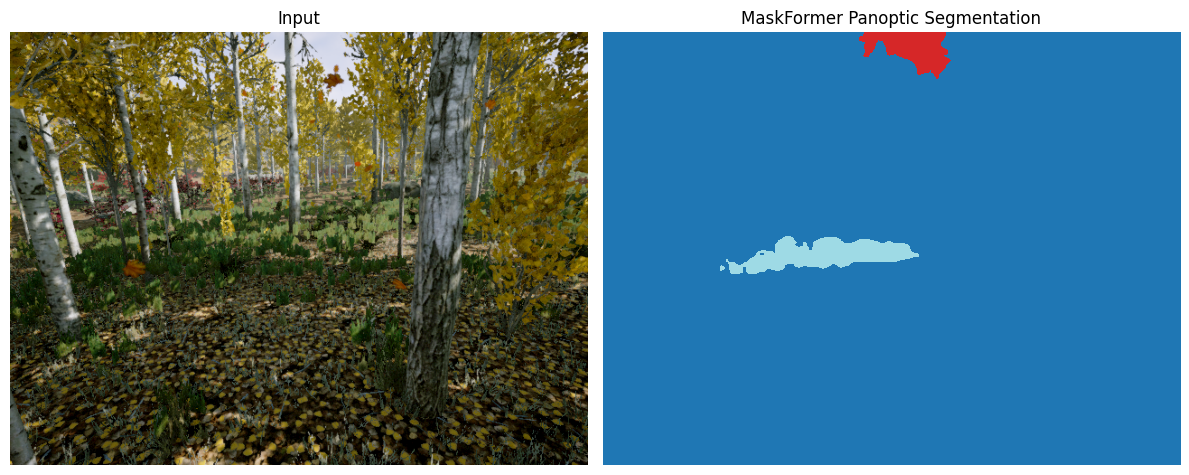

In [24]:
import torch


# Make the SwinBackbone return hidden states (per-stage features)
seg_model.model.pixel_level_module.encoder.config.output_hidden_states = True
seg_model.model.pixel_level_module.encoder.config.return_dict = True

# Prepare input
from PIL import Image
img = image1
inputs = seg_processor(images=img, return_tensors="pt").to(seg_model.device)
with torch.no_grad():
    # Run the whole model while capturing the backbone output via a forward hook
    _captured = {}
    def _enc_hook(_m, _in, out):
        _captured["bb_out"] = out
    _h = seg_model.model.pixel_level_module.encoder.register_forward_hook(_enc_hook)
    seg_outputs = seg_model(**inputs)
    _h.remove()

bb_out = _captured["bb_out"]


# What you get:
# bb_out.hidden_states -> tuple of tensors after each stage norm (C1..C4)
# bb_out.feature_maps  -> same features but kept in 2D map form (useful for decoder)
print([t.shape for t in bb_out.hidden_states])   # e.g., [(B, H1*W1, C1), ..., (B, H4*W4, C4)]
print([t.shape for t in bb_out.feature_maps])    # e.g., [(B, C1, H1, W1), ..., (B, C4, H4, W4)]

# If you specifically want the output right after patch+pos embedding (pre-stage1),
# take the first element.
c1_tokens = bb_out.hidden_states[0]     # (B, N1, 128) for Swin-B
c4_map    = bb_out.feature_maps[-1]     # (B, 1024, H/32, W/32)


seg_result = seg_processor.post_process_semantic_segmentation(
    outputs=seg_outputs, target_sizes=[image1.size[::-1]]
)[0]  # (H, W) tensor with class ids

# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Panoptic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
(bb_out.feature_maps[0].shape,  # (B, 128, H/4, W/4) for Swin-B
bb_out.feature_maps[1].shape , # (B, 256, H/8, W/8) for Swin-B
bb_out.feature_maps[2].shape ,# (B, 512, H/16, W/16) for Swin-B
bb_out.feature_maps[3].shape) # (B, 1024, H/32, W/32) for Swin-B

(torch.Size([1, 128, 96, 96]),
 torch.Size([1, 256, 48, 48]),
 torch.Size([1, 512, 24, 24]),
 torch.Size([1, 1024, 12, 12]))